# Module Description

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

More details about the dataset, including algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html. The dataset is made available under a [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/) license.

## Table of Contents
- [Module Description](#Module-Description)
    - [Packages' Installation](#Packages'-Installation)
    - [Const Variables Declaraion](#Const-Variables-Declaraion)
    - [Global Functions Declaration](#Global-Functions-Declaration)
    - [Data Upload](#Data-Upload)
    - [Data Evaluation](#Data-Evaluation)
        - [First look](#First-look)
        - [Nan Values](#Nan-Values)

## Packages' Installation

* **[ggplot2](https://ggplot2.tidyverse.org/)** - the package for the data portroyal
* **[repr](https://cran.r-project.org/web/packages/repr/index.html)** - specify an object and a format to represent it in.

In [39]:
library(ggplot2)
library(repr)
library(scales)
library(caret)
library(nnet)

## Const Variables Declaraion

- **theme_settings** - define the settings for figure

- **ubyte_data** - The data from the [MNIST database](http://yann.lecun.com/exdb/mnist/index.html) differs from the Kaggle's data. Thus I've implemented two options of data reading. Apparently, I was using `csv` reading, however if you'd like so, you may load the `ubyte` by setting `ubyte_data` as `TRUE`.

- **label_index** - MNIST labels store in the distinct files, therefore I add them up as a unique field (column) to the appropriate dataset. Though the Kaggl's data contains the label as the first element. I do change this variable depends on which dataset I use.

In [13]:
theme_settings <- theme(axis.text=element_text(size=14),
        axis.title=element_text(size=16),
        legend.title=element_text(size=16),
        legend.text=element_text(size=16))

ubyte_data <- FALSE

label_index <- 1

## Global Functions Declaration

In [14]:
if (ubyte_data){
    # load image files
    load_image_file <- function(filename) {
      ret = list()
      f = file(filename, 'rb')
      readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      n    = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      nrow = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      ncol = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      x = readBin(f, 'integer', n = n * nrow * ncol, size = 1, signed = FALSE)
      close(f)
      data.frame(matrix(x, ncol = nrow * ncol, byrow = TRUE))
    }

    # load label files
    load_label_file <- function(filename) {
      f = file(filename, 'rb')
      readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      n = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      y = readBin(f, 'integer', n = n, size = 1, signed = FALSE)
      close(f)
      y
    }
    
    label_index <- 785
}

# helper function for visualization
show_digit = function(arr784, col = gray(12:1 / 12), ...) {
  image(matrix(as.matrix(arr784[-label_index]), nrow = 28)[, 28:1], col = col, ...)
}

## Data Upload

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

```
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
```

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

```
ImageId,Label
1,3
2,7
3,8 
(27997 more lines)
```

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

In [15]:
if (ubyte_data) {
    # load images
    train <- load_image_file("data/train-images.idx3-ubyte")
    train$label = as.factor(load_label_file("data/train-labels.idx1-ubyte"))

    # load labels
    test  <- load_image_file("data/t10k-images.idx3-ubyte")
    test$label  = as.factor(load_label_file("data/t10k-labels.idx1-ubyte"))
} else {
    train <- read.csv('data/train.csv')
    test <- read.csv('data/test.csv')
}

The data looks like:

In [16]:
head(train)

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


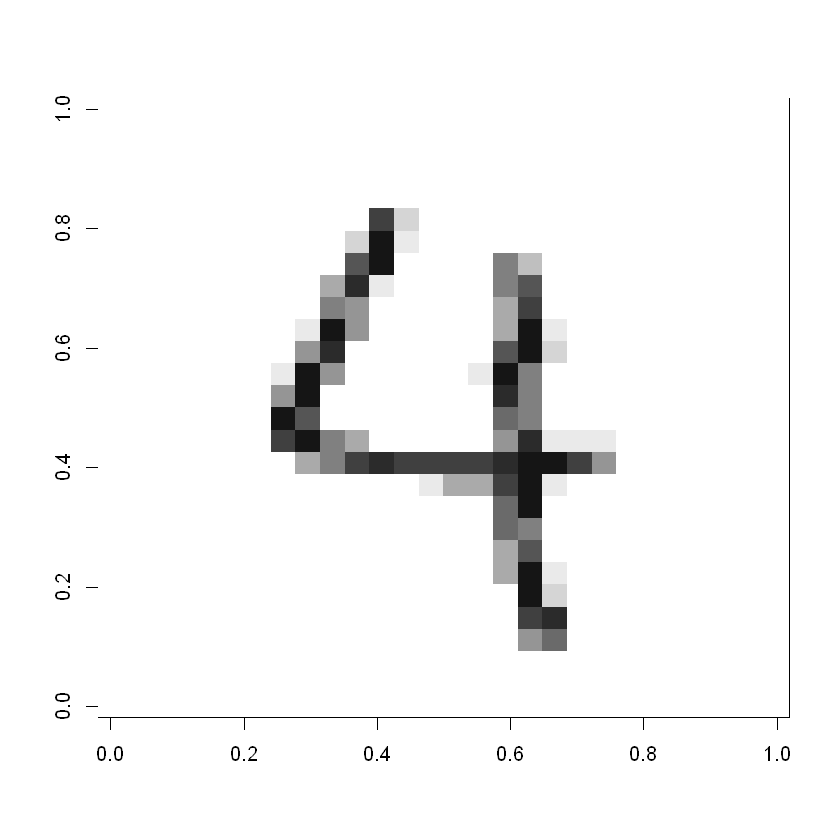

In [17]:
show_digit(train[1000,])

## Data Evaluation

In [18]:
is.factor(train$label)

[1] FALSE

In [19]:
train$label <- as.factor(train$label)
is.factor(train$label)

[1] TRUE

### First look

Create new table 10x2:
- 1 - **digit** contains unique digit in range [0;9]
- 2 - **amount** the quantity of these digits

In [20]:
tbl <- data.frame(with(train, table(train$label)))
colnames(tbl) <- c('digit', 'amount')

Take a look the data distribution in the train data. 
The amount of every single digit is pretty equal. It approaches to the 10% of each one. It will help us select the right metric to evaluate a model.

In [21]:
barplot <- ggplot(tbl, aes(x=digit, y=amount, fill=digit)) +
  geom_bar(stat="identity") + 
  geom_text(aes(label = scales::percent((amount)/sum(amount))), position = position_stack(vjust = 0.9), size = 6) + theme_settings
options(repr.plot.width=16,repr.plot.height=6)

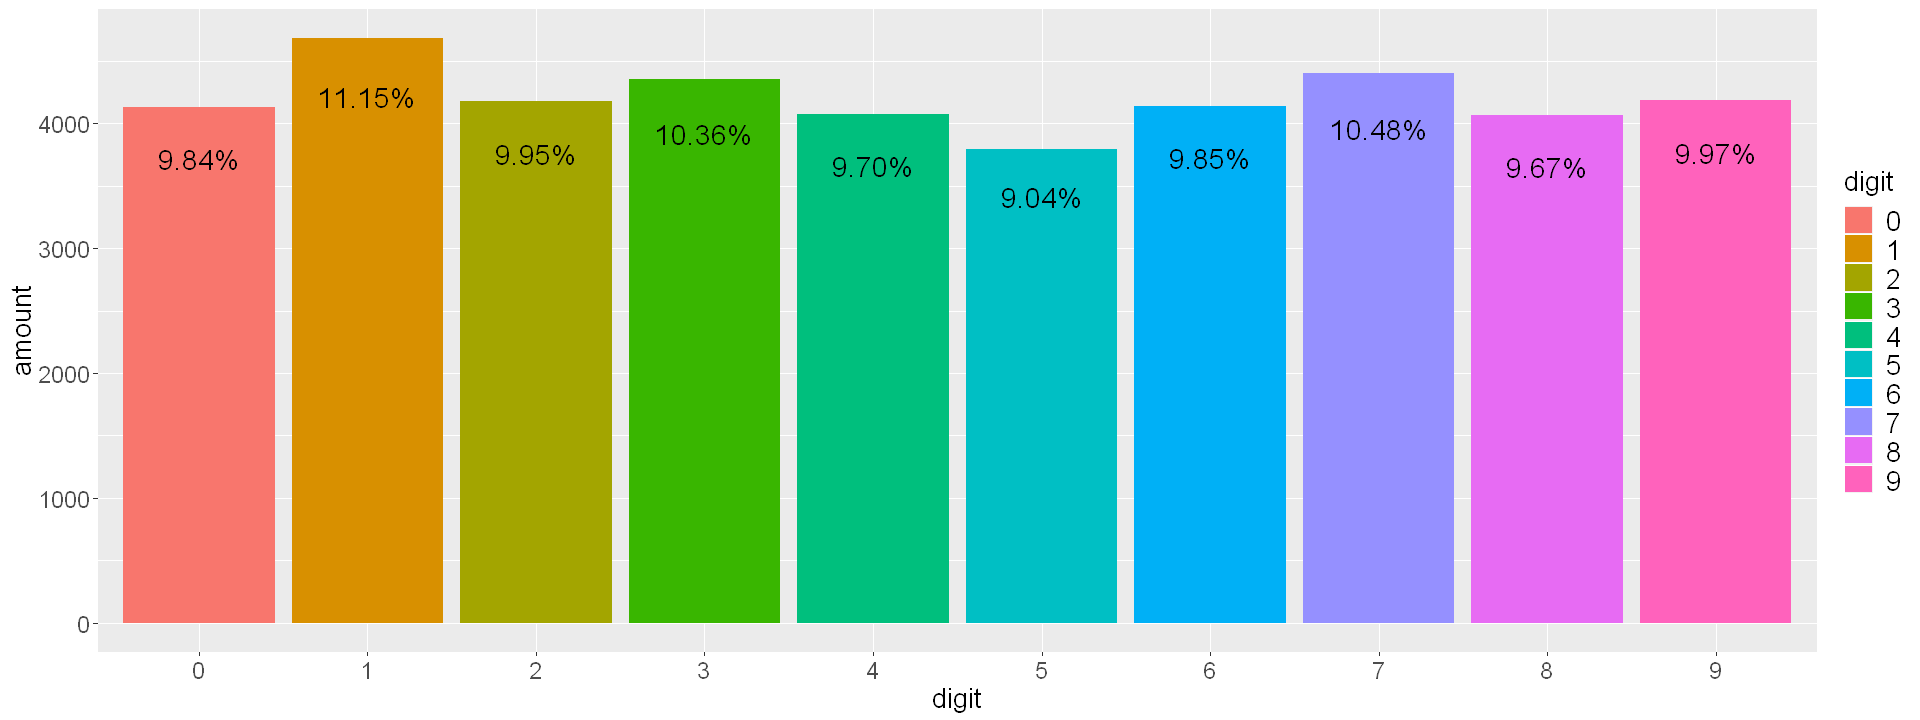

In [22]:
barplot
rm(tbl)
options(repr_option_defaults)

### Nan-Values
Check for nan-values. Nothing at all.

In [23]:
sum(is.na(train))
sum(is.na(test))

[1] 0

[1] 0

### Pixel Distribution in the Center of Image

Let's check the feature distribution in the center of image. For these purposes I took 4 pixels in the center and plot histograms of their intensity for each digit. The brightness of the pixels is varying from digit to digit, and it's pretty logcally: For instance, when you write `8` in majority of cases its junction point is in the center, or really close to. However for the `7` the situation is opposite, it almost never cross through the central pixels.

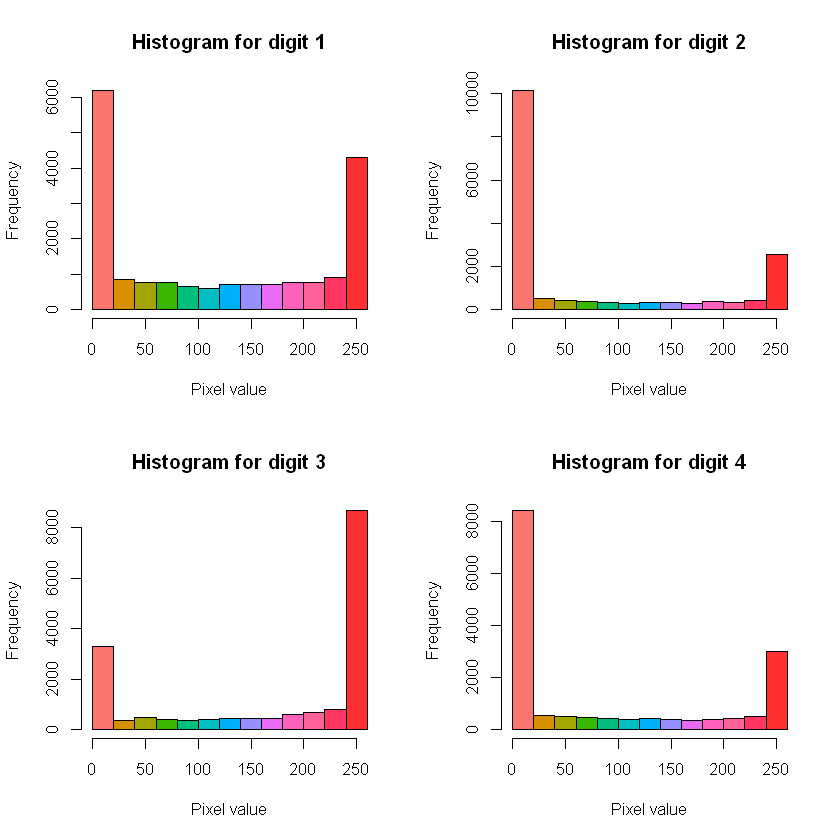

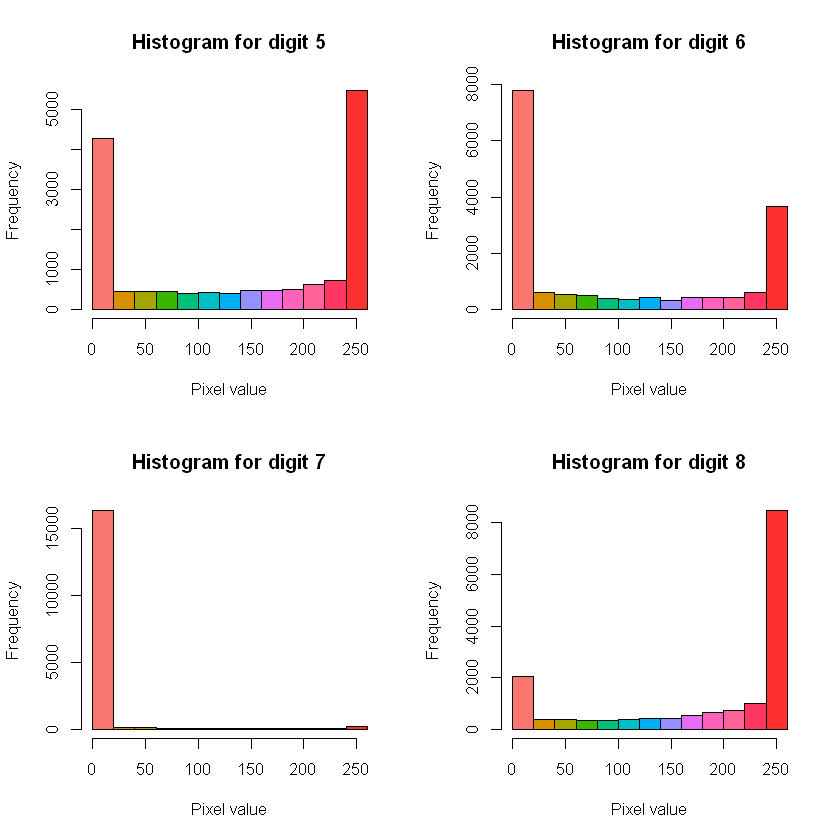

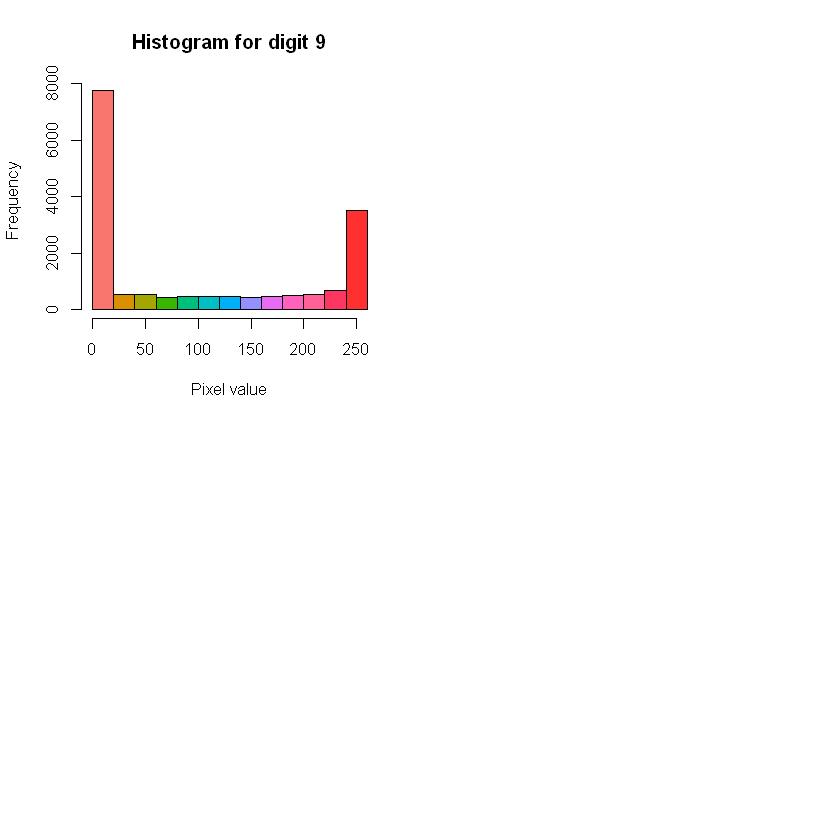

In [34]:
central_block <- c("pixel376", "pixel377", "pixel404", "pixel405")
par(mfrow=c(2, 2))
for(i in 1:9) {
hist(c(as.matrix(train[train$label==i, central_block])), 
col = c("#F8766D","#D89000", "#A3A500", "#39B600", "#00BF7D", "#00BFC4", "#00B0F6", "#9590FF", "#E76BF3", "#FF62BC", "#FF6299", "#FF3661", "#FF3030"),
main=sprintf("Histogram for digit %d", i),
xlab="Pixel value")
}

In [36]:
set.seed(42)
train_split_index <- createDataPartition(train$label, p=0.8, list=FALSE)

In [38]:
train_split <- train[train_split_index,]
test_split <- train[-train_split_index,]

### Data Normalization

In purpose to reduce the [illumination effect](https://www.sciencedirect.com/science/article/pii/S0924271617303878) and bolster CNN performance (it's better working with [0;1] rather than [0;255]) perform a grayscale normalization.

Shorthand of the grayscale normalization

$$
I:\{\mathbb{X} \subseteq \mathbb{R}^n\} \rightarrow \{\text{Min}, .., \text{Max}\} - \text{the n-dimensional image with intensity values in the range (Min,Max) required to be grayscaled.}
$$

$$
I_N:\{\mathbb{X} \subseteq \mathbb{R}^n\} \rightarrow \{\text{newMin}, .., \text{newMax}\} - \text{new image with new intensity values in the range (newMin,newMax).}
$$

The linear (linear relationship between old pixels and new ones) normalization of a grayscale digital image is performed according to the formula

$$
I_N = (I - \text{Min}) \times \frac{\text{newMax} - \text{newMin}}{\text{Max} - \text{Min}} + \text{newMin}
$$

In our case: $I_N = (\text{each_pixel} - 0) \times \frac{1 - 0}{255 - 0} + 0 = \frac{(\text{each_pixel})}{255}$

In [13]:
train[-1] <- train[-1]/255.0
test <- test/255.0